This notebook uses the recently-added support for doing volume rendering of [RAMSES](https://bitbucket.org/rteyssie/ramses/src/master/) datasets using the [yt](yt-project.com) project.

A key ingredient in the formation of disky galaxy in the early stages of the Universe (in its first $\sim 3\mathrm{Gyr}$) is the acquisition of angular momentum that support the rotation of the forming disk.
One important channel uncovered in recent research is through "cold" gas filaments, defined as gas that _never_ heats above $2\times 10^5\mathrm{K}$.
This gas has a peculiar thermal history as well as a peculiar evolution, which could potentially contribute to our understanding of how galaxies spin up.

In this notebook, I am using the output from one of my simulations at $1.75\ \mathrm{Gyr}$ ($z=3.6$) after the Big Bang, focused on one particular galaxy. The simulation has an exquisite resolution of $100 \mathrm{ly}$ ($30 \mathrm{pc}$), so that the galaxy is well-resolved.
In order to find the gas that _never_ heats above $2\times 10^5\mathrm{K}$, I rely on a tracer particle scheme, developed in [Cadiou, _et al._ (2019)](https://www.aanda.org/articles/aa/abs/2019/01/aa34496-18/aa34496-18.html), that allows me to sample the trajectory of the gas as it falls onto the galaxy using particles. For each of them, I check the temperature at all times and keep only those that remained cool the entire way down.
I then project the particles onto the simulation grid to find cells containing cold gas and make a volume rendering out of it.
The tracer particle that track the cold gas have their ids stored in the file `ids_cold_gas.txt`.

# Installing requirements

First install the dependencies. You first need cython, numpy, h5py and (optionally) tqdm.
An important note: this notebook relies on a version of yt that hasn't been integrated in the main, public version as of May 31.
In the meantime, you can use my own fork of yt with the integrated changes by using the cell below.

In [ ]:
%%bash

# Clone my version of yt, and install it
cd /path/to/temporary_folder/
git clone https://github.com/cphyc/yt.git
git checkout indep-octree-raytracing
# Make sure you have cython and numpy installed *before* issuing this command
pip install .

In [10]:
import yt
import numpy as np
from tqdm.auto import tqdm
import numpy as np

# Load the data

In [ ]:
%%bash
# Download data into a new folder
# a word of caution here: this will require about 20Gio of space on your hard drive!
mkdir -p data
cd data
[[ ! -e output_00111.tar.gz ]] && wget http://use.yt/upload/a7fb5eee
[[ ! -e output_00111/info_00111.txt ]] && tar xf output_00111.tar.gz

mkdir -p plots

Load the ids of the particle selected and the dataset.

In [2]:
cold_gas_tracer_ids = np.loadtxt('ids_cold_gas.txt', dtype=int)

# These values are such that the box is centred around one galaxy, with the right boundaries
center, w = np.array([0.50300061, 0.49767861, 0.49692033]), 0.02166748046875
bbox = center-w, center+w

# Load the dataset. The bbox parameter ensures that we're not reading data
# outside the region of interest and speeds things up (and saves a lot of RAM!)
ds = yt.load('data/output_00111/info_00111.txt', bbox=bbox)

yt : [INFO     ] 2020-05-31 19:29:38,276 Parameters: current_time              = 2.5525434507448876
yt : [INFO     ] 2020-05-31 19:29:38,277 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2020-05-31 19:29:38,277 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2020-05-31 19:29:38,278 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2020-05-31 19:29:38,279 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2020-05-31 19:29:38,279 Parameters: current_redshift          = 3.5666829167139156
yt : [INFO     ] 2020-05-31 19:29:38,280 Parameters: omega_lambda              = 0.691100001335144
yt : [INFO     ] 2020-05-31 19:29:38,280 Parameters: omega_matter              = 0.308899998664856
yt : [INFO     ] 2020-05-31 19:29:38,281 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2020-05-31 19:29:38,281 Parameters: hubble_constant           = 0.6773999786376951


Let us use yt to create a particle filter to only retains the cold gas, based on the list of cold gas tracers.
I can then flag cells that contains one of these tracers to easily identify cold flows.

In [3]:
@yt.particle_filter(name='cold_gas', requires=['particle_identity'], filtered_type='gas_tracer')
def cold_gas(pfilter, data):
    return np.in1d(data[(pfilter.filtered_type, 'particle_identity')].value.astype(int), cold_gas_tracer_ids)

ds.add_particle_filter('cold_gas')
ds.add_deposited_particle_field(('cold_gas', 'particle_mass'), method='cic')

yt : [WARNING  ] 2020-05-31 19:29:38,298 Detected 1 extra gravity fields.
yt : [INFO     ] 2020-05-31 19:29:49,940 Adding particle_type: DM
yt : [INFO     ] 2020-05-31 19:29:49,958 Adding particle_type: star
yt : [INFO     ] 2020-05-31 19:29:49,974 Adding particle_type: cloud
yt : [INFO     ] 2020-05-31 19:29:49,992 Adding particle_type: dust
yt : [INFO     ] 2020-05-31 19:29:50,009 Adding particle_type: star_tracer
yt : [INFO     ] 2020-05-31 19:29:50,025 Adding particle_type: cloud_tracer
yt : [INFO     ] 2020-05-31 19:29:50,042 Adding particle_type: dust_tracer
yt : [INFO     ] 2020-05-31 19:29:50,059 Adding particle_type: gas_tracer


('deposit', 'cold_gas_cic_mass')

Now that we have flagged cells that contained at least one tracer particle, we can extract the region containing the cold gas.

In [4]:
sp = ds.box(bbox[0], bbox[1])
reg = sp.cut_region(['obj[("deposit", "cold_gas_cic_mass")] > 0'])

# Temperature

Here we will make 3D volume rendering of the temperature using blue shades.

In [63]:
sc = yt.create_scene(reg, field=('gas', 'temperature'), lens_type='perspective')
source = sc[0]
sc.camera.focus = (sp.center).to('unitary').value
sc.camera.position = bbox[1]
sc.camera.resolution = (2048, 2048)

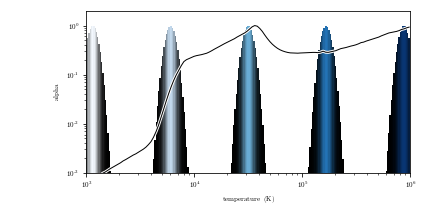

In [64]:
bounds = (1e3, 1e6)

tf = yt.ColorTransferFunction(np.log10(bounds), grey_opacity=True)
tf.add_layers(5, colormap='Blues')
source.tfh.tf = tf
source.tfh.bounds = bounds
source.tfh.log = True

source.tfh.plot(None, profile_field='temperature')

In [65]:
for i, j in tqdm(zip(sc.camera.iter_rotate(np.pi, n_steps=400, rot_center=sp.center),
                     sc.camera.iter_zoom(3, n_steps=400)), total=400):
    sc.save('plots/temperature_%04i.png' % i, sigma_clip=1)

yt : [INFO     ] 2020-05-31 21:08:01,896 Rendering scene (Can take a while).
yt : [INFO     ] 2020-05-31 21:08:01,903 Creating volume
yt : [INFO     ] 2020-05-31 21:08:15,765 Saving render plots/temperature_0000.png
yt : [INFO     ] 2020-05-31 21:08:17,928 Rendering scene (Can take a while).
yt : [INFO     ] 2020-05-31 21:08:18,878 Saving render plots/temperature_0001.png
yt : [INFO     ] 2020-05-31 21:08:21,035 Rendering scene (Can take a while).
yt : [INFO     ] 2020-05-31 21:08:22,029 Saving render plots/temperature_0002.png
yt : [INFO     ] 2020-05-31 21:08:24,200 Rendering scene (Can take a while).
yt : [INFO     ] 2020-05-31 21:08:25,168 Saving render plots/temperature_0003.png
yt : [INFO     ] 2020-05-31 21:08:27,329 Rendering scene (Can take a while).
yt : [INFO     ] 2020-05-31 21:08:28,236 Saving render plots/temperature_0004.png
yt : [INFO     ] 2020-05-31 21:08:30,408 Rendering scene (Can take a while).
yt : [INFO     ] 2020-05-31 21:08:31,389 Saving render plots/temperatur

# Density

Now let's make some plots of the density, this time using the matplotlib's "inferno" colormap (which gives a nice yellowish color to densest regions).

In [60]:
sc = yt.create_scene(reg, field=('gas', 'density'), lens_type='perspective')
source = sc[0]
sc.camera.focus = (sp.center).to('unitary').value
sc.camera.position = bbox[1]
sc.camera.resolution = (2048, 2048)

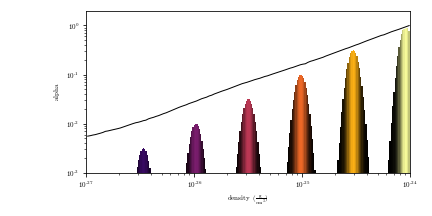

In [61]:
bounds = (1e-27, 1e-24)

tf = yt.ColorTransferFunction(np.log10(bounds), grey_opacity=False)
tf.add_layers(7, colormap='inferno')
source.tfh.tf = tf
source.tfh.bounds = bounds
source.tfh.log = True

source.tfh.plot(None, profile_field='density')

In [62]:
for i, j in tqdm(zip(sc.camera.iter_rotate(np.pi, n_steps=400, rot_center=sp.center),
                     sc.camera.iter_zoom(3, n_steps=400)), total=400):
    sc.save('plots/density_%04i.png' % i, sigma_clip=2)

yt : [INFO     ] 2020-05-31 20:46:14,499 Rendering scene (Can take a while).
yt : [INFO     ] 2020-05-31 20:46:14,506 Creating volume
yt : [INFO     ] 2020-05-31 20:46:28,548 Saving render plots/density_0000.png
yt : [INFO     ] 2020-05-31 20:46:30,633 Rendering scene (Can take a while).
yt : [INFO     ] 2020-05-31 20:46:31,427 Saving render plots/density_0001.png
yt : [INFO     ] 2020-05-31 20:46:33,490 Rendering scene (Can take a while).
yt : [INFO     ] 2020-05-31 20:46:34,288 Saving render plots/density_0002.png
yt : [INFO     ] 2020-05-31 20:46:36,317 Rendering scene (Can take a while).
yt : [INFO     ] 2020-05-31 20:46:37,111 Saving render plots/density_0003.png
yt : [INFO     ] 2020-05-31 20:46:39,137 Rendering scene (Can take a while).
yt : [INFO     ] 2020-05-31 20:46:39,930 Saving render plots/density_0004.png
yt : [INFO     ] 2020-05-31 20:46:41,946 Rendering scene (Can take a while).
yt : [INFO     ] 2020-05-31 20:46:42,748 Saving render plots/density_0005.png
yt : [INFO   

# Merge density and temperature layers together

This requires the imagemagick package. When using conda, you can install it using
```bash
conda install -c conda-forge imagemagick
```

In [68]:
%%bash

cd plots/
for ii in {0..399}; do
    i=$(printf "%04d" $ii)
    j=$(python -c "print(int(max(0, (300-int($ii))/3)))")
    echo composite -blend ${j}x100 temperature_$i.png density_$i.png temp_dens_$i.png
    echo convert temp_dens_$i.png -gravity center -crop 1920x1080+0+0 temp_dens_${i}_UHD.png
done | xargs -I{} --max-procs $OMP_NUM_THREADS /bin/sh -c "{}"

Now, let's make a video out of the frames. This requires ffmpeg, which you can also install using
```bash
conda install -c conda-forge ffmpeg openh264
```

In [59]:
%%bash
cd plots
rm temp_dens.mp4
cat temp_dens_????_UHD.png \
    | ffmpeg -f image2pipe -framerate 20 -i - -vcodec libx264 -pix_fmt yuv420p temp_dens_HD.mp4

rm: cannot remove `temp_dens.mp4': No such file or directory
ffmpeg: error while loading shared libraries: libopenh264.so.5: cannot open shared object file: No such file or directory


CalledProcessError: Command 'b'cd plots\nrm temp_dens.mp4\ncat temp_dens_????.png \\\n    | ffmpeg -f image2pipe -framerate 20 -i - -vcodec libx264 -pix_fmt yuv420p temp_dens.mp4\n'' returned non-zero exit status 127.